A notebook to process results of the compression task on CelebA where the input set contains three images, weighted in various ways.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import kbrgan
import kbrgan.kernel as kernel
import kbrgan.glo as glo
import kbrgan.main as main
import kbrgan.net.net as net
import kbrgan.gen as gen
import kbrgan.plot as plot
import kbrgan.embed as embed
import kbrgan.util as util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
tensor_type = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.set_default_tensor_type(tensor_type)

## Plot results

In [5]:
case_name = 'interpolation_v1'
root_results_folder = glo.result_folder('3imgs_compression', case_name)

Get the input images

In [6]:
import glob
import skimage
    
def get_np_input_images(root_results_folder):
    """
    Return a numpy stack of input images. 
    """
    subfolders = glob.glob(os.path.join(root_results_folder, 'face_interpolation_test_*'))
    subfolder2 = glob.glob(subfolders[0] + '/*')
    input_folder = os.path.join(subfolder2[0], 'input_images')
    input_fpaths = glob.glob(input_folder + '/*')
    # need to sort. glob.glob does not necessarily return a sorted list
    arg = np.argsort([os.path.basename(fp) for fp in input_fpaths])
    input_fpaths = [input_fpaths[i] for i in arg]
    list_imgs = []
    for img_fpath in input_fpaths:
        img = skimage.io.imread(img_fpath)
#         print(img.shape)
        list_imgs.append(img)
    return np.stack(list_imgs, axis=0)

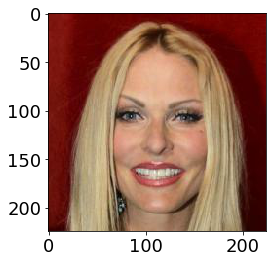

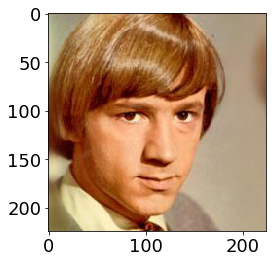

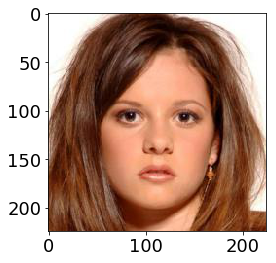

In [7]:
import skimage
in_imgs = get_np_input_images(root_results_folder)
for i in range(in_imgs.shape[0]):
    plt.figure()
    plt.imshow(in_imgs[i])

In [8]:
import re
def get_candidate_weights(root_results_folder):
    """
    Return a numpy array of size n x 3 (of type string) where 
    n is the number of candidate input weight vectors. 
    """
    case_folders = glob.glob(os.path.join(root_results_folder, 'face_interpolation_test*'))
    list_weights = []
#     pat = r'(\d+(\.\d+)?)_(\d+(\.\d+)?)_(\d(\.\d+)?)\.sh'
    pat = r'face_interpolation_test_(\d+(\.\d+)?)_(\d+(\.\d+)?)_(\d(\.\d+)?)'
    for shf in case_folders:
        sh_fname = os.path.basename(shf)
#         print(sh_fname)
        m = re.match(pat, sh_fname)
#         print(m.group(3))
        w = np.array([m.group(i) for i in [1,3,5]])
        list_weights.append(w)
    return np.stack(list_weights, axis=0)

In [9]:
np_str_weights = get_candidate_weights(root_results_folder)
np_str_weights

array([['0.4', '0.2', '0.4'],
       ['0.5', '0.25', '0.25'],
       ['0', '0.5', '0.5'],
       ['0.5', '0.5', '0'],
       ['0', '0', '1'],
       ['0.3333', '0.3333', '0.3333'],
       ['0.25', '0.25', '0.5'],
       ['0.25', '0.5', '0.25'],
       ['0.2', '0.4', '0.4'],
       ['1', '0', '0'],
       ['0.4', '0.4', '0.2'],
       ['0', '1', '0'],
       ['0.5', '0', '0.5']], dtype='<U6')

In [10]:
def get_output_img(root_results_folder, weights, verbose=False):
    """
    Return the output image (assume there is only one) given 
    one vector of input weights.
    
    * weights: a numpy array with one dimension. Each value is a string.
    """
    subfolder = 'face_interpolation_test_{}_{}_{}'.format(*weights)
    case_path = os.path.join(root_results_folder, subfolder )
    subfolders = glob.glob(case_path)
    subfolder2 = glob.glob(subfolders[0] + '/*')
    
    output_folder = os.path.join(subfolder2[0], 'output_images')
    iter_fpaths = glob.glob(output_folder + '/*')
#     print([os.path.basename(fname) for fname in iter_fpaths])
    arg = np.argsort([int(os.path.basename(fname)) for fname in iter_fpaths])
    # highest iteration
    last_iter_folder = iter_fpaths[arg[-1]]
    out_fpaths = glob.glob(last_iter_folder + '/*')
    # expect only one output image
    assert len(out_fpaths) == 1
    
    # load the image
    if verbose:
        print('Loading output image: {}'.format(out_fpaths[0]))
    return skimage.io.imread(out_fpaths[0])
    

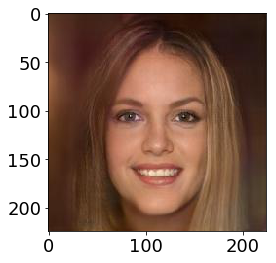

In [11]:
# Test get_output_img()
img = get_output_img(root_results_folder, np_str_weights[0])
plt.imshow(img)

In [12]:
# load all output images. Each output image corresponds to one input weight vector
list_out_imgs = []
for i, weights in enumerate(np_str_weights):
    loaded = get_output_img(root_results_folder, weights)
    list_out_imgs.append(loaded)
    
# stack
out_imgs = np.stack(list_out_imgs, axis=0)

Input images


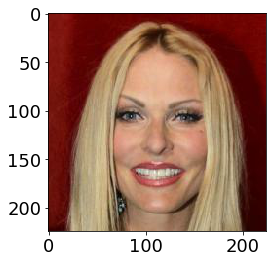

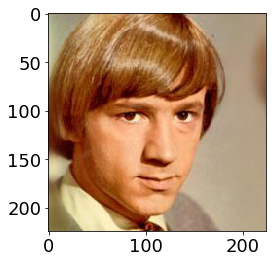

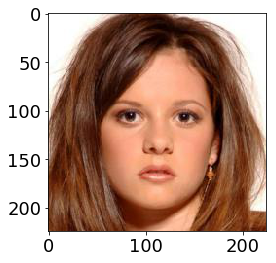

In [13]:
# show input images
print('Input images')
for i in range(in_imgs.shape[0]):
    plt.figure()
    plt.imshow(in_imgs[i])

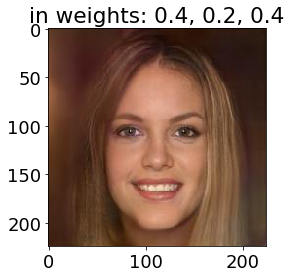

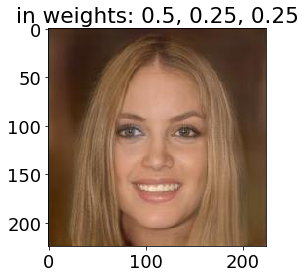

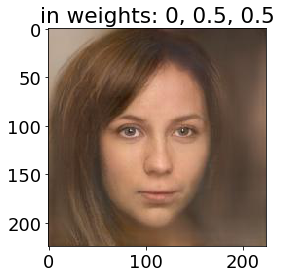

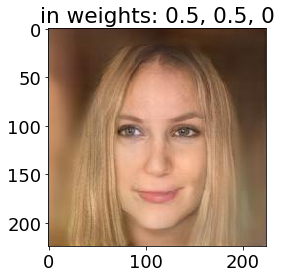

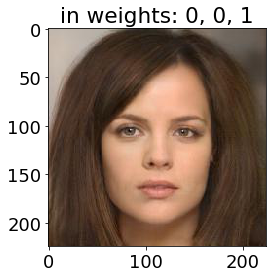

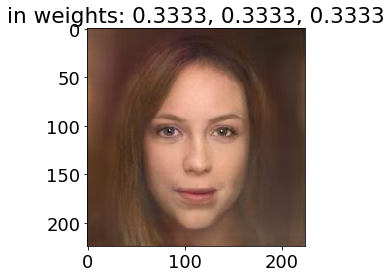

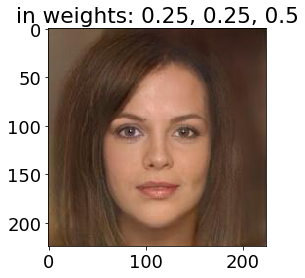

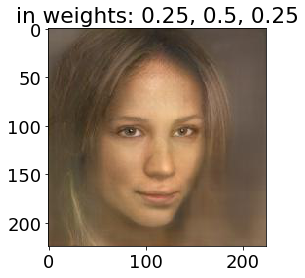

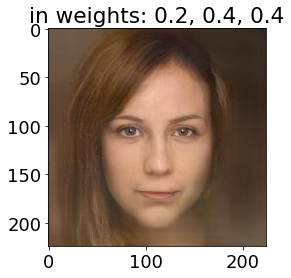

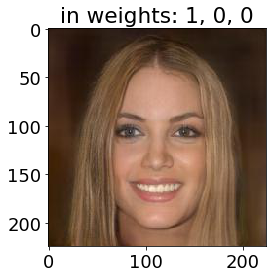

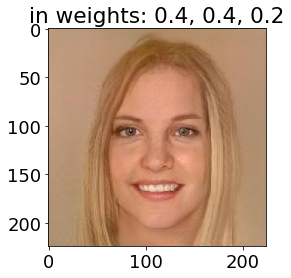

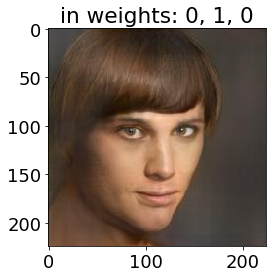

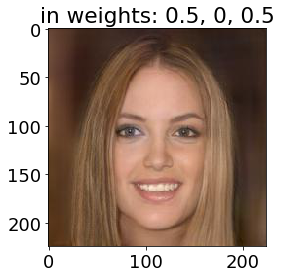

In [14]:
for i in range(out_imgs.shape[0]):
    oimg = out_imgs[i]
    plt.figure()
    plt.imshow(oimg)
    Wi = np_str_weights[i]
    plt.title('in weights: {}, {}, {}'.format(Wi[0], Wi[1], Wi[2]))

In [15]:
def proj2d(x):
    """
    x is a vector of 3 coordinates in the 2-dimensional simplex
    Project onto the equilateral triangle on 2d where the lower 
    left corner is at the origin. All three sides have unit length.
    
    """
    from functools import reduce
    xcol = x[:, np.newaxis]
    v1 = np.array([[-1, 1, 0.0]]).T
    v2 = np.array([[-1, 0.0, 1]]).T
#     A = np.hstack((v1, v2))/np.sqrt(2)
    A = np.hstack((v1, v2))
    ATA = A.T.dot(A)
    e1 = np.array([[1, 0, 0.0]]).T
#     print(A.T)
    pro = reduce(np.dot, [np.linalg.inv(ATA), A.T, xcol-e1])
#     print(pro)
    # reconstruct with a new 2d axes
    e1_2d = np.array([[1, 0]]).T
    r2 = np.array([[np.cos(np.pi/3), np.sin(np.pi/3)]]).T
    R = np.hstack((e1_2d, r2))
#     return pro
    return R.dot(pro)

In [16]:
candidate_weights = np_str_weights.astype(np.float64)

In [17]:
def plot_triangle(in_imgs, candidate_weights,  out_imgs, img_zoom=0.25,
                 axis_margin=0.15, figsize=(8,8)):
    
    from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    # Fix the display limits to see everything
    ax.set_xlim(0-axis_margin, 1.0+axis_margin)
    ax.set_ylim(0-axis_margin, np.sqrt(1**2 - 0.5**2)+axis_margin)
    ax.set_aspect('equal')
#     ax.axis('off')

    # draw triangle
    plt.plot([0, 0.5], [0, np.sqrt(3/4.0)], 'k')
    plt.plot([0.5, 1], [np.sqrt(3/4.0), 0], 'k')
    plt.plot([0, 1], [0, 0], 'k')
    
    # plot three input images at the three corners of the triangle
    center = np.array([0.5, np.sqrt(3/4.0)/2])
    corners = np.array([
        [0, 0], [1, 0], [0.5, np.sqrt(3/4.0)]
    ])
    for i in range(3):
        imbox = OffsetImage(in_imgs[i], zoom=img_zoom)
        imbox.image.axes = ax
        ab = AnnotationBbox(imbox, corners[i],
                    xybox=(4., -4.),
#                     xycoords='data',
                    boxcoords="offset points",
                    pad=0.5,
                    arrowprops=dict(
                        arrowstyle="->",
                        connectionstyle="angle,angleA=0,angleB=90,rad=3")
                    )
        ax.add_artist(ab)
        
        # annotate text x1, x2, x3
        ax.annotate('x{}'.format(i+1), xy=corners[i], fontsize=12)
#     return
    
    # Go through each weight vector and plot the output image
    for i in range(candidate_weights.shape[0]):
        Wi = candidate_weights[i]
        Wi_2d = proj2d(Wi)

        # output image
        oimg = out_imgs[i]
        imagebox = OffsetImage(oimg, zoom=img_zoom)
        imagebox.image.axes = ax

        xy = (Wi_2d[0, 0], Wi_2d[1, 0])
        print('({:.2f}, {:.2f}, {:.2f}) |-> ({:.2f}, {:.2f})'.format(
            Wi[0], Wi[1], Wi[2],
            xy[0], xy[1]))
        ab = AnnotationBbox(imagebox, xy,
                            xybox=(30., -30.),
        #                     xycoords='data',
                            boxcoords="offset points",
                            pad=0.0,
                            arrowprops=dict(
                                arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=3")
#                                 connectionstyle="angle,rad=3")
                            )
        ax.add_artist(ab)
        # annotate with text showing weights
#         ax.annotate(
#             '{}'.format(Wi), 
#             xy=Wi_2d.reshape(-1)+np.array([0,0.07]), 
#             fontsize=10)

    plt.show()

(0.40, 0.20, 0.40) |-> (0.40, 0.35)
(0.50, 0.25, 0.25) |-> (0.38, 0.22)
(0.00, 0.50, 0.50) |-> (0.75, 0.43)
(0.50, 0.50, 0.00) |-> (0.50, 0.00)
(0.00, 0.00, 1.00) |-> (0.50, 0.87)
(0.33, 0.33, 0.33) |-> (0.50, 0.29)
(0.25, 0.25, 0.50) |-> (0.50, 0.43)
(0.25, 0.50, 0.25) |-> (0.62, 0.22)
(0.20, 0.40, 0.40) |-> (0.60, 0.35)
(1.00, 0.00, 0.00) |-> (0.00, 0.00)
(0.40, 0.40, 0.20) |-> (0.50, 0.17)
(0.00, 1.00, 0.00) |-> (1.00, 0.00)
(0.50, 0.00, 0.50) |-> (0.25, 0.43)


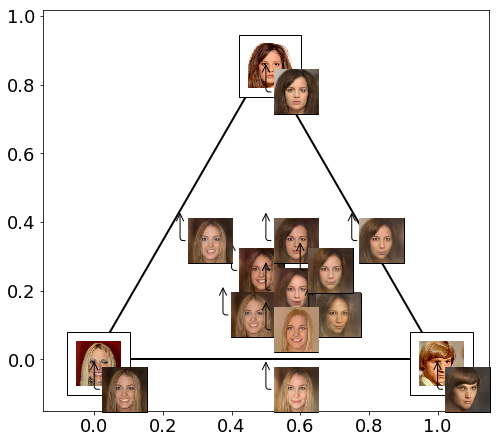

In [18]:
plot_triangle(in_imgs, candidate_weights, out_imgs, img_zoom=0.2)

## Candidate list of weight vectors

In [102]:
def vdc(n, base=2):
    # Van der Corput sequence
    vdc, denom = 0,1
    while n:
        denom *= base
        n, remainder = divmod(n, base)
        vdc += remainder / denom
    return vdc


def vdc2(n_sample, base=2):
    """Van der Corput sequence.
    :param int n_sample: number of element of the sequence.
    :param int base: base of the sequence.
    :return: sequence of Van der Corput.
    :rtype: list (n_samples,)
    """
    sequence = []
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence

def get_vdc_candidate_weights(n, base=2):
    V = [vdc(i, base) for i in range(n+2)]
    v1 = V[:n]
    v2 = V[1:(n+1)]
    v3 = V[2:(n+2)]
    # stack
    H = np.hstack((
        np.array(v1).reshape(n, 1),
        np.array(v2).reshape(n, 1),
        np.array(v3).reshape(n, 1),        
             ))
    # normalize
    N = H / np.sum(H, 1, keepdims=True)

    return N

In [169]:
def get_vdc_candidate_weights2(n, base=2):
    nr = int(n**(1.0/3)) + 1
    V = [vdc(i, base) for i in range(nr)]
    L = []
    for i in range(nr):
        for j in range(i, nr):
            for k in range(j, nr):
                L.append((V[i], V[j], V[k]))
#     H = np.vstack([(v1, v2, v3) for v1 in V for v2 in V for v3 in V])
    H = np.vstack(L)
    H = H[1:]
    # normalize
#     print(H)

    # remove (0,0,0)
#     H = H[2:]
    N = H / np.sum(H, 1, keepdims=True)
    return N[:n]

In [170]:
[vdc(i, base=2) for i in range(15)]

[0,
 0.5,
 0.25,
 0.75,
 0.125,
 0.625,
 0.375,
 0.875,
 0.0625,
 0.5625,
 0.3125,
 0.8125,
 0.1875,
 0.6875,
 0.4375]

In [171]:
CW = get_vdc_candidate_weights2(8, base=2)
CW

array([[0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.5       , 0.5       ],
       [0.        , 0.66666667, 0.33333333],
       [0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333],
       [0.4       , 0.4       , 0.2       ],
       [0.5       , 0.25      , 0.25      ]])

In [172]:
projCW = np.hstack([proj2d(w) for w in CW]).T
projCW

array([[0.5       , 0.8660254 ],
       [0.5       , 0.8660254 ],
       [0.75      , 0.4330127 ],
       [0.83333333, 0.28867513],
       [0.75      , 0.4330127 ],
       [0.5       , 0.28867513],
       [0.5       , 0.17320508],
       [0.375     , 0.21650635]])

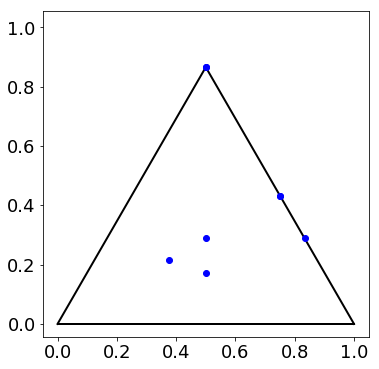

In [173]:
# draw triangle
plt.figure(figsize=(6,6))
plt.plot([0, 0.5], [0, np.sqrt(3/4.0)], 'k')
plt.plot([0.5, 1], [np.sqrt(3/4.0), 0], 'k')
plt.plot([0, 1], [0, 0], 'k')
   
for i in range(projCW.shape[0]):
    wi = projCW[i]
    plt.plot(wi[0], wi[1], 'bo')
    
plt.axis('square');